<a href="https://colab.research.google.com/github/Tahimi/convectionDiffusion/blob/main/diffusion1D_FiniteDiference2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# mounting the drive
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# space discretization
import numpy as np

xL = 0.
delX = 50.
xR = xL + delX
nx = 100
dx = delX/nx
x = np.linspace(xL, xR, nx+1)

print('xL = x[0] = ', x[0], '\n'
      'xR = x[-1] = ', x[-1], '\n'
      'dx = ', dx, '\n'
      'nx = ', nx)

xL = x[0] =  0.0 
xR = x[-1] =  50.0 
dx =  0.5 
nx =  100


In [3]:
# time discretization

tL = 0.0
delT = 5.
tR = tL + delT

# diffusion-based time step size, dt
D = 10.
Fr = 0.5 # Fourier Number: Fr = D*dt/dx**2
dt = abs(Fr*dx**2/D)

nt = int(delT/dt)
t = np.linspace(tL, tR, nt+1)

print('tL = t[0] = ', t[0], '\n'
      'tR = t[-1] = ', t[-1], '\n'
      'D = ', D, '\n'
      'Fr = ', Fr, '\n'
      'dt = Fr*dx**2/D = ', dt, '\n'
      'nt = ', nt)

tL = t[0] =  0.0 
tR = t[-1] =  5.0 
D =  10.0 
Fr =  0.5 
dt = Fr*dx**2/D =  0.0125 
nt =  400


In [4]:
# definig the time instants for the saving of y

savingFreq = 4
delIdx = int(len(t)/savingFreq)
save_times = t[range(0, len(t), delIdx)]

closest_idx = lambda val, arr: np.abs(arr - val).argmin()
save_indices = [closest_idx(save_time, t) for save_time in save_times]

print('save_times = ', save_times, '\n'
      'save_indices = ', save_indices)

save_times =  [0.   1.25 2.5  3.75 5.  ] 
save_indices =  [0, 100, 200, 300, 400]


In [5]:
# defining the unkown's distribution
def distributionIn1D(x, yMin, yMax, xc, width, isRectangular = True):
  if isRectangular:
    # rectangular distribuition
    return np.array([yMax if xc-width < xi and xi < xc+width else yMin for xi in x])
  else:
    # Gaussian distribuition
    return yMin + yMax * np.exp(-(x - xc) ** 2 / (2 * width ** 2))

In [6]:
# initialization
yMin, yMax = 0., 1.
xc, width = 25., 2. # source epicenter and width

def initialize():
    # unkown's initialization
    global x, yMin, yMax, xc, width
    yInit = distributionIn1D(x=x,
                             yMin=yMin,
                             yMax=yMax,
                             xc=xc,
                             width=width,
                             isRectangular=False)
    return yInit

yInit = initialize()

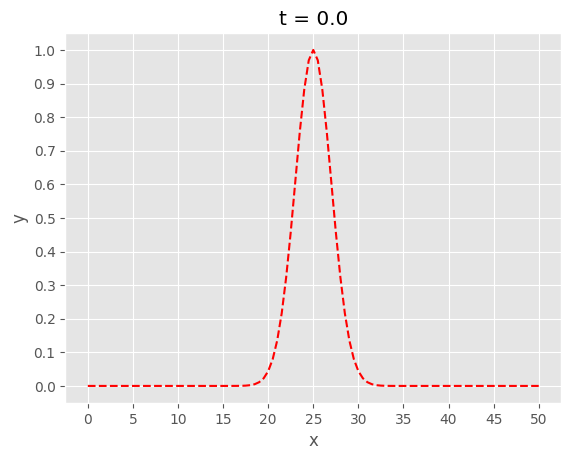

In [7]:
# plotting the initial distribution of y
import matplotlib.pyplot as plt

# define plot style
plt.style.use("ggplot")

# Create the figure and axis
fig, ax = plt.subplots()

# set axis labels
ax.set_xlabel('x')
ax.set_ylabel('y')

# set plot parameters
xmin, xmax, ymin, ymax = xL, xR, 0., 1.
boxOffset, xEpsilon, yEpsilon = 0.1, dx/10, 1e-8
xticksFeq, yticksFreq = 10, 10

# set figure bounding box
ax.set_xbound(lower=xmin-boxOffset, upper=xmax+boxOffset)
ax.set_ybound(lower=ymin-boxOffset, upper=ymax+boxOffset)

# set axis ticks
plt.xticks(np.arange(xmin, xmax+xEpsilon, (xmax-xmin)/xticksFeq))
plt.yticks(np.arange(ymin, ymax+yEpsilon, (ymax-ymin)/yticksFreq))

# set plot data and title
lineInit, = ax.plot(x, yInit, color='r', linestyle='dashed')
plotTitle = ax.set_title("t = " + str(tL))

In [8]:
# defining the time-step update function
# ExplicitFirstOrderDiffusionFiniteDiferenceScheme
# ForwardFirstOrderAccurateInTime
# centredSecondOrderAccurateInSpace
def diffuse1(yIN, Fr):
  yOUT = np.zeros_like(yIN)
  # internal points
  for i in range(1,len(x)-1):
    yOUT[i] = Fr*yIN[i-1] + (1.-2*Fr)*yIN[i] + Fr*yIN[i+1]
  # closed BC (Neumann), no leaving material, i.e. grad(y) = 0
  yOUT[0] = (1.-2*Fr)*yIN[0] + 2.*Fr*yIN[1]
  yOUT[-1] = 2.*Fr*yIN[-2] + (1.-2*Fr)*yIN[-1]
  return yOUT

In [9]:
# Loop over time, calculate y and save it at save_times
import pandas as pd

# create a pandas data frame  to save data
df = pd.DataFrame(data={'x':x})

# initialize y
y = yInit

# define time's and df column's names upon time value
tiSTR = lambda ti: str(round(ti,3))
yColumnName = lambda ti: f'y_{tiSTR(ti)}'

# iterate over time
for i, ti in enumerate(t):
    if i in save_indices:
        df[yColumnName(ti)] = y
    y = diffuse1(y, Fr)

# display dataframe head
df.head(3)

,x,y_0.0,y_1.25,y_2.5,y_3.75,y_5.0
0,0.0,1.176911e-34,0.000012,0.001629,0.008577,0.019423
1,0.5,2.596224e-33,0.000014,0.001670,0.008671,0.019540
2,1.0,5.380186e-32,0.000018,0.001794,0.008956,0.019893


In [10]:
# plotting the initial distribution of y
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# define plot style
plt.style.use("ggplot")

# Create the figure and axis
fig, ax = plt.subplots()

# set axis labels
ax.set_xlabel('x')
ax.set_ylabel('y')

# set plot parameters
xmin, xmax, ymin, ymax = xL, xR, 0., 1.
boxOffset, xEpsilon, yEpsilon = 0.1, dx/10, 1e-8
xticksFeq, yticksFreq = 10, 10

# set figure bounding box
ax.set_xbound(lower=xmin-boxOffset, upper=xmax+boxOffset)
ax.set_ybound(lower=ymin-boxOffset, upper=ymax+boxOffset)

# set axis ticks
plt.xticks(np.arange(xmin, xmax+xEpsilon, (xmax-xmin)/xticksFeq))
plt.yticks(np.arange(ymin, ymax+yEpsilon, (ymax-ymin)/yticksFreq))

# set plot data and title
lineInit, = ax.plot(x, yInit, color='r', label='yInit')
plotTitle = ax.set_title("t = " + str(tL))

# define plot data variable (without initializing it)
line, = ax.plot(x, y*np.nan, color='b', linestyle='dashed', label='y')

# adding the legend
ax.legend()

# close the figure (to show only the animation)
plt.close(fig)

# Update line and plotTitle for the animation
def update(time_idx):
    ti = t[time_idx]
    y = df[yColumnName(ti)]
    line.set_ydata(y)
    plotTitle.set_text('t = ' + tiSTR(ti))
    return line,

# Set up the animation
ani = FuncAnimation(fig, update, frames=save_indices, interval=200, blit=False)

# Save the animation as a GIF
gifFileName = '/content/drive/MyDrive/UFAL/advection_diffusion/FiniteDiference_FipyFiniteVolume/animated1DConvDiffFiniteDiference2.gif'
ani.save(gifFileName, writer='pillow')

# Display the animation
HTML(ani.to_jshtml())